In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as sm
import numpy as np
import math

In [2]:
# Read in data
raw_df = pd.read_csv('../data/MERGED2016_17_PP.csv',
                     header=0,
                     low_memory=False)

raw_df = raw_df.append(pd.read_csv('../data/MERGED2015_16_PP.csv',
                     header=0,
                     low_memory=False))

raw_df = raw_df.append(pd.read_csv('../data/MERGED2014_15_PP.csv',
                     header=0,
                     low_memory=False))

raw_df = raw_df.append(pd.read_csv('../data/MERGED2013_14_PP.csv',
                     header=0,
                     low_memory=False))

In [3]:
div_adm = ["UNITID", "ADM_RATE","SAT_AVG", 
           "UGDS", "UGDS_WHITE",
           "UGDS_BLACK", "UGDS_HISP",
           "UGDS_ASIAN" #, 
           #"UGDS_AIAN",
           #"UGDS_NHPI"
          ]


In [4]:
# Remove majority/historic diverse schools
# Select demographics of interest
print(len(raw_df))
names = raw_df[(raw_df["HBCU"] == 1) | (raw_df["PBI"] == 1) | 
                  (raw_df["ANNHI"] == 1) | (raw_df["TRIBAL"] == 1) |
                  (raw_df["AANAPII"] == 1) | (raw_df["HSI"] == 1)]
names = names[['UNITID']]
# filtered = raw_df[(raw_df["HBCU"] == 0) & (raw_df["PBI"] == 0) & 
#                   (raw_df["ANNHI"] == 0) & (raw_df["TRIBAL"] == 0) &
#                   (raw_df["AANAPII"] == 0) & (raw_df["HSI"] == 0)]
print(len(raw_df))
filtered = raw_df[~raw_df['UNITID'].isin(names['UNITID'])]
#filtered = raw_df
print(len(filtered))

df = filtered[div_adm]
df = df.round(2)

df['buck_adm'] = pd.cut(df['ADM_RATE'], bins=10, precision=2)
df['buck_sat'] = pd.cut(df['SAT_AVG'], bins=15, precision=0)
df = df[['buck_adm', 'buck_sat', 'UGDS_BLACK', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_HISP']].dropna()
print(len(df))

30275
30275
27356
4458


In [5]:
"""
CONFIDENCE INTERVAL CALCULATIONS
"""

buck_sat = sorted(df.buck_sat.unique())
races = ['UGDS_BLACK', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_HISP']
results = {'UGDS_BLACK':[], 'UGDS_WHITE':[], 'UGDS_ASIAN':[], 'UGDS_HISP':[]}
for race in races:
    all_data = df[race]
    groups = [df[df['buck_sat'] == bucket][race] for bucket in buck_sat]
    
    alpha = 0.1
    n = len(all_data)
    k = len(buck_sat)
    CM = np.power(np.sum(all_data),2)
    T1 = np.sum(np.power(all_data,2))
    T2 = 0
    t = scipy.stats.t.ppf(1- (alpha / 2), n - k)
    
    for group in groups:
        values = group.values
        length = len(values)
        T2 += 1 / length * np.power(np.sum(values),2)
    
    SSE = T1 - T2
    MSE = SSE / (n - k)
    S = np.sqrt(MSE)
    
    for index in range(len(buck_sat)):
        if index > 0:
            groupLeft = groups[index - 1].values
            groupRight = groups[index].values
            left_average = np.average(groupLeft)
            right_average = np.average(groupRight)
            lower_ci = right_average - left_average - t * np.sqrt(1 / len(groupLeft) + 1 / len(groupRight))
            upper_ci = right_average - left_average + t * np.sqrt(1 / len(groupLeft) + 1 / len(groupRight))
            results[race].append([lower_ci,upper_ci])
            
print(results)


{'UGDS_BLACK': [[-0.56319531540108514, 0.42210369746736193], [-0.44084256963686497, 0.25948964646575989], [-0.21787160653266599, 0.12117311358176666], [-0.12006086924143797, 0.077103851186691358], [-0.10703231634345278, 0.047336404555742173], [-0.10206753412341651, 0.05531836034296761], [-0.10869584427801224, 0.087673102526526991], [-0.13998026990391296, 0.11422214776293996], [-0.16802056927483353, 0.15636894714595698], [-0.20063379630460901, 0.19409527670515245], [-0.2122634784109988, 0.22718975080674952], [-0.23942178921989027, 0.24964390529345126], [-0.26848809624178693, 0.2872986246725685], [-0.47763927425141162, 0.4435122901244275]], 'UGDS_WHITE': [[-0.35849745965059776, 0.62680155321784925], [-0.25103846801458163, 0.44929374808804323], [-0.11179771251224768, 0.22724700760218497], [-0.059991853516336319, 0.13717286691179301], [-0.051246294099609735, 0.10312242679958522], [-0.07071104112235746, 0.086674853344026664], [-0.10569787399785154, 0.090671072806687694], [-0.139630508643103

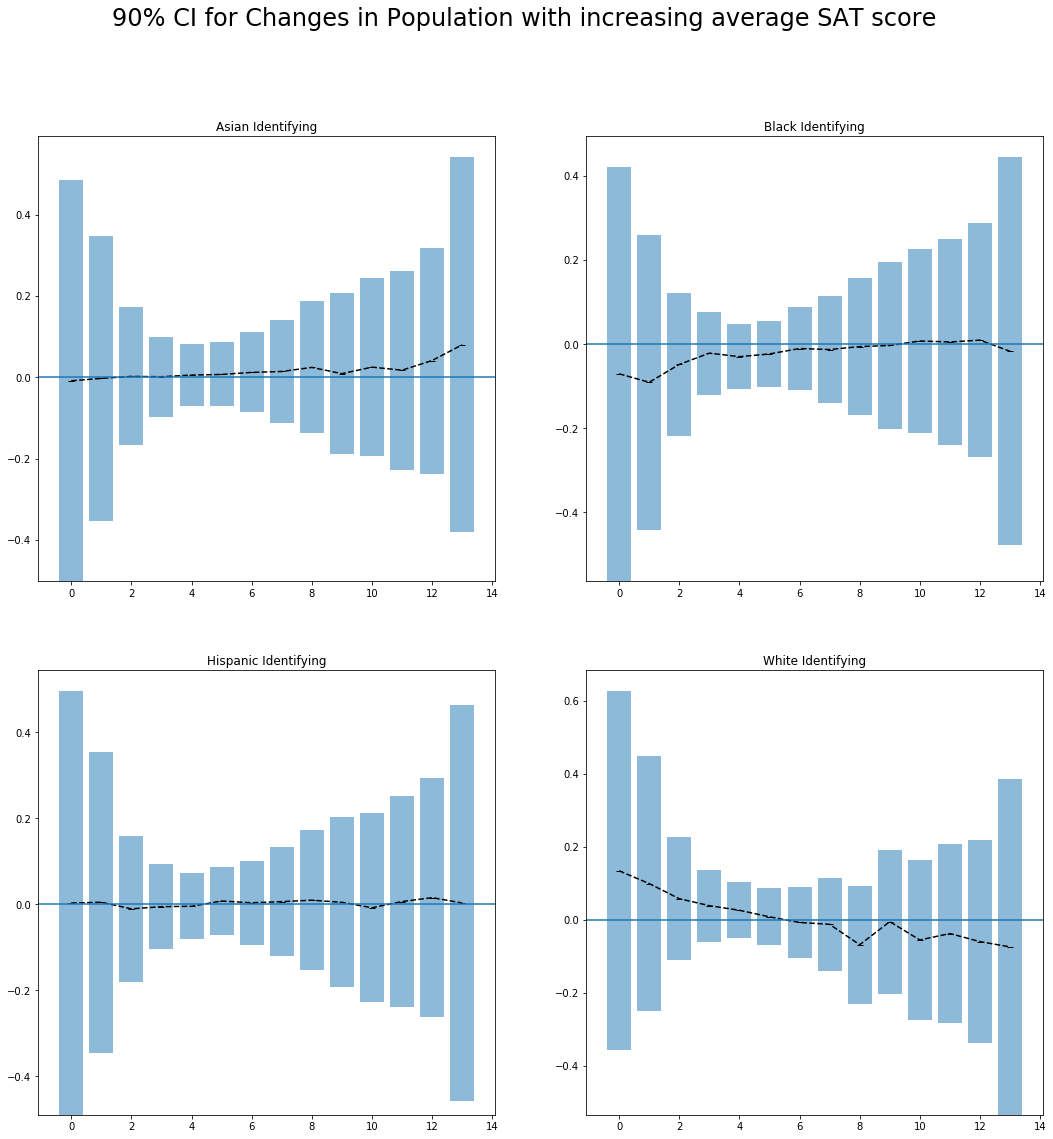

In [6]:
# Black Identifying
import matplotlib.lines as mlines
plt.subplots(2,2, figsize=(18,18))

plt.subplot(221)
height = [ci[1] - ci[0] for ci in results['UGDS_ASIAN']]
bottom_ci = [ci[0] for ci in results['UGDS_ASIAN']]
average = [(ci[0] + ci[1]) / 2 for ci in results['UGDS_ASIAN']]
positions = np.arange(len(buck_sat) - 1)
plt.title('Asian Identifying')
plt.bar(positions,height,align='center', alpha=0.5,bottom=bottom_ci)
plt.plot(positions,average,color='black', linestyle='dashed', marker='_')
ax = plt.gca()
xmin, xmax = ax.get_xbound()
l = mlines.Line2D([xmin,xmax], [0,0])
ax.add_line(l)



plt.subplot(222)
height = [ci[1] - ci[0] for ci in results['UGDS_BLACK']]
bottom_ci = [ci[0] for ci in results['UGDS_BLACK']]
average = [(ci[0] + ci[1]) / 2 for ci in results['UGDS_BLACK']]
positions = np.arange(len(buck_sat) - 1)
plt.title('Black Identifying')
plt.bar(positions,height,align='center', alpha=0.5,bottom=bottom_ci)
plt.plot(positions,average,color='black', linestyle='dashed', marker='_')
ax = plt.gca()
xmin, xmax = ax.get_xbound()
l = mlines.Line2D([xmin,xmax], [0,0])
ax.add_line(l)

plt.subplot(223)
height = [ci[1] - ci[0] for ci in results['UGDS_HISP']]
bottom_ci = [ci[0] for ci in results['UGDS_HISP']]
average = [(ci[0] + ci[1]) / 2 for ci in results['UGDS_HISP']]
positions = np.arange(len(buck_sat) - 1)
plt.title('Hispanic Identifying')
plt.bar(positions,height,align='center', alpha=0.5,bottom=bottom_ci)
plt.plot(positions,average,color='black', linestyle='dashed', marker='_')
ax = plt.gca()
xmin, xmax = ax.get_xbound()
l = mlines.Line2D([xmin,xmax], [0,0])
ax.add_line(l)

plt.subplot(224)
height = [ci[1] - ci[0] for ci in results['UGDS_WHITE']]
bottom_ci = [ci[0] for ci in results['UGDS_WHITE']]
average = [(ci[0] + ci[1]) / 2 for ci in results['UGDS_WHITE']]
positions = np.arange(len(buck_sat) - 1)
plt.title('White Identifying')
plt.bar(positions,height,align='center', alpha=0.5,bottom=bottom_ci)
plt.plot(positions,average,color='black', linestyle='dashed', marker='_')
ax = plt.gca()
xmin, xmax = ax.get_xbound()
l = mlines.Line2D([xmin,xmax], [0,0])
ax.add_line(l)


plt.suptitle('90% CI for Changes in Population with increasing average SAT score',fontsize=24)
plt.savefig('diversity_confidence_intervals.jpg')

plt.show()

